In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Exercises: Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
#setting up a column for size of megabytes
df['size_mb'] = df['size'] / 1024 / 1024
#passing df through pd.to_datetime for date and time format/dtype
df.timestamp = pd.to_datetime(df.timestamp)
#setting timestamp as the index
df = df.set_index('timestamp')

### Looking at IP:

In [4]:
#looking at the value counts of IP (head)
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [5]:
#turning value counts into percentages
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
Name: ip, dtype: float64

In [6]:
#looking at the value counts of IP (tail)
df.ip.value_counts().tail()

34.207.64.242    1
3.88.129.158     1
52.91.30.150     1
52.90.165.200    1
45.23.250.16     1
Name: ip, dtype: int64

In [7]:
#turning tail() into percentages
df.ip.value_counts(normalize=True).tail()

34.207.64.242    0.000072
3.88.129.158     0.000072
52.91.30.150     0.000072
52.90.165.200    0.000072
45.23.250.16     0.000072
Name: ip, dtype: float64

### Takeaways: Ip address 97.105...address holds the most weight of these logs.

In [8]:
#defining a function to combine the above:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
    s.value_counts(dropna=False).rename('count'),
    s.value_counts(dropna=False, normalize=True).rename('proba'),
    left_index=True,
    right_index=True,
    )

In [9]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


<AxesSubplot:>

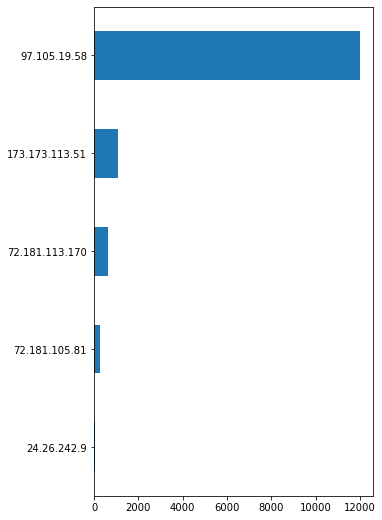

In [10]:
#finding how many unique ip addresses there are:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

________________________________________

### Looking for anomalies for timestamp:

In [11]:
#looking at value count by timestamp to find any anomalies in query frequencies:
df.index.value_counts()

2019-04-16 19:56:10    9
2019-04-16 19:49:58    8
2019-04-16 20:01:30    7
2019-04-16 20:12:23    6
2019-04-16 20:02:59    6
                      ..
2019-04-16 21:10:09    1
2019-04-16 21:10:07    1
2019-04-16 21:10:05    1
2019-04-16 21:10:03    1
2019-04-17 12:55:14    1
Name: timestamp, Length: 9953, dtype: int64

In [12]:
#looking at the timestamp that has the highest frequency occuring
df[df.index == '2019-04-16 19:56:10']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:56:10,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.20.1,0.000040
2019-04-16 19:56:10,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040
2019-04-16 19:56:10,97.105.19.58,GET,/api/v1/sales?page=48,HTTP/1.1,200,513027,python-requests/2.21.0,0.489261
2019-04-16 19:56:10,97.105.19.58,GET,/documentation,HTTP/1.1,200,348,python-requests/2.20.1,0.000332
2019-04-16 19:56:10,97.105.19.58,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,0.000332
2019-04-16 19:56:10,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.20.1,0.003396
2019-04-16 19:56:10,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:56:10,97.105.19.58,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
2019-04-16 19:56:10,97.105.19.58,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.20.1,0.003489


### Takeaways: 
Not only is it strange that so many queries happened at once from the same IP address, but the request paths are also all varying. Because the status_code is clear, I would think that this IP address must have made a SQL query and is downloading all of these tables and docs for a project. 
<br><br>That or there is some website scrapping happening.

In [13]:
#looking at the timestamp that has the second highest frequency occuring
df[df.index == '2019-04-16 19:49:58']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/sales?page=122,HTTP/1.1,200,510104,python-requests/2.21.0,0.486473
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/sales?page=158,HTTP/1.1,200,510316,python-requests/2.21.0,0.486675
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0.003489
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1//api/v1/items/next_page,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:49:58,97.105.19.58,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,python-requests/2.21.0,0.001704
2019-04-16 19:49:58,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154


### Takeaways:
This group definitely sends a red flad as the user_agent looks like it is coming from one computer and then another ( python vs browser).
I would flag this IP address or find out more information as to who this is.

In [14]:
#looking at the timestamp that has the third highest frequency occuring
df[df.index == '2019-04-16 20:01:30']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/sales?page=110,HTTP/1.1,200,511980,python-requests/2.21.0,0.488262
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0.003489
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/sales?page=110,HTTP/1.1,200,511980,python-requests/2.20.1,0.488262
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/sales?page=158,HTTP/1.1,200,510316,python-requests/2.21.0,0.486675
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/sales?page=68,HTTP/1.1,200,510133,python-requests/2.21.0,0.486501
2019-04-16 20:01:30,97.105.19.58,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,python-requests/2.21.0,0.001704


In [15]:
#and then the timestamp with the 4th highest:
df[df.index == '2019-04-16 20:12:23']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 20:12:23,97.105.19.58,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,0.000332
2019-04-16 20:12:23,97.105.19.58,GET,/api/v1/sales?page=174,HTTP/1.1,200,510143,python-requests/2.20.1,0.486510
2019-04-16 20:12:23,97.105.19.58,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
2019-04-16 20:12:23,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 20:12:23,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 20:12:23,97.105.19.58,GET,/api/v1/sales?page=152,HTTP/1.1,200,510120,python-requests/2.21.0,0.486488


In [16]:
#and then the timestamp with the 4th highest:
df[df.index == '2019-04-16 20:02:59']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 20:02:59,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040
2019-04-16 20:02:59,97.105.19.58,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,0.000332
2019-04-16 20:02:59,97.105.19.58,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266
2019-04-16 20:02:59,97.105.19.58,GET,/api/v1/sales?page=139,HTTP/1.1,200,513236,python-requests/2.20.1,0.489460
2019-04-16 20:02:59,97.105.19.58,GET,/api/v1/sales?page=99,HTTP/1.1,200,512312,python-requests/2.21.0,0.488579
2019-04-16 20:02:59,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040


In [21]:
ts_df = value_counts_and_frequencies(df.index)
ts_df.head()

,count,proba
2019-04-16 19:56:10,9,0.000644
2019-04-16 19:49:58,8,0.000572
2019-04-16 20:01:30,7,0.000501
2019-04-16 20:12:23,6,0.000429
2019-04-16 20:02:59,6,0.000429


<AxesSubplot:>

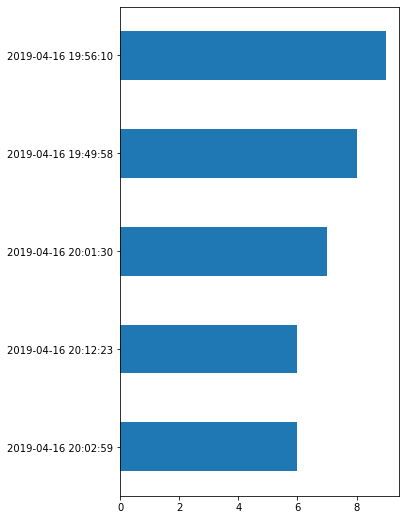

In [22]:
ts_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

_______________________________________________

### Looking at request_method:

In [17]:
#finding any request methods that are not GET:
df[df.request_method != 'GET']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,


### Takeaways: 
It looks like GET (or downloading) is the only request method happening in all of the logs.

______________________________________________________________

### Looking at request_path:

In [18]:
df.request_path.value_counts()

/api/v1/sales?page=2                 709
/api/v1/items                        464
/api/v1/items?page=2                 291
/api/v1/items?page=3                 219
/api/v1/stores                       162
                                    ... 
/api/v1/items?page=0                   1
/api/v1/stores?page=999                1
/api/v1/stores?page=2                  1
/api/v1/stores?page=666                1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 218, dtype: int64

In [45]:
#finding the anomalies at the tail-end of everything...funny names...
df.request_path.value_counts().tail(30)

/api/v1/sales?page=161                     59
/api/v1/sales?page=137                     59
/api/v1/sales?page=1                       57
/api/v1/stores?page=1                      56
/favicon.ico                               26
/api/v1//api/v1/items?page=2               10
/api/v1/items/api/v1/items?page=2           6
/api/v1/items/next_page                     5
/api/v1/stores?page=3                       4
/api/v1/                                    4
/api/v1/itemsitems                          3
/api/v1/store                               3
/api/v1/sales/?page=2                       3
/api/v1/stores?page=0                       2
/api/v1/stores?page=183                     2
/api/v1items                                2
/api/v1/items?page=4                        1
/api/v1/items&page=0                        1
/api/v1/items?page=99999999999999999998     1
/api/V1/HiZach!                             1
/api/v1/I_DIDNT_DO_IT!!!!                   1
/api/v1/helloclass!               

_____________________________________________

### Looking at status_code:

In [36]:
#value_counts() of the status_codes:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

### Takeaways:
499 codes are telling that "the client shut off in the middle of processing the request through the server"(belugcna.com).
<br><br>This possibly could be when students close their notebooks during long queries?

_______________________________________________

### Looking at size_mb:

In [44]:
df.size_mb.value_counts().tail()

0.312356    1
0.343606    1
0.265481    1
0.327981    1
0.390481    1
Name: size_mb, dtype: int64

________________________________________

### Looking at user_agent counts:

In [50]:
#taking in all the value counts of user_agent:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [ ]:
### Takeaways:
In looking up the 